<a href="http://landlab.github.io"><img style="float: left" src="../../../landlab_header.png"></a>

# linear diffusion exercise with Landlab

This notebook was created by Nicole Gasparini at Tulane University.

<hr>
For tutorials on learning Landlab, click here: <a href="https://github.com/landlab/landlab/wiki/Tutorials">https://github.com/landlab/landlab/wiki/Tutorials</a>
<hr>


**Let's go!**

Note that if you are running this on the EarthScape Hub, you should be in the CSDMS kernel. (_Kernel_ pulldown menu, _Change Kernel..._ 

Import statements. You should not need to edit this.

In [1]:
# below is to make plots show up in the notebook
%matplotlib inline

In [2]:
# Code Block 1

import numpy as np
from matplotlib.pyplot import figure, legend, plot, show, title, xlabel, ylabel, ylim, xlim, imshow

from landlab.plot.imshow import imshow_grid

We will create a grid with 41 rows and 5 columns, and dx is 5 m (a long, narrow, hillslope). The initial elevation is 0 at all nodes.

We set-up boundary conditions so that material can leave the hillslope at the two short ends.

In [33]:
# Code Block 2

# setup grid
from landlab import RasterModelGrid

mg = RasterModelGrid((100, 5), 2.0)
z_vals = mg.add_zeros("topographic__elevation", at="node")

# initialize some values for plotting
ycoord_rast = mg.node_vector_to_raster(mg.node_y)
ys_grid = ycoord_rast[:, 2]

# set boundary condition. Only south boundary is open
mg.set_closed_boundaries_at_grid_edges(True, True, True, False)

Now we import and initialize the *LithoLayers* component. 

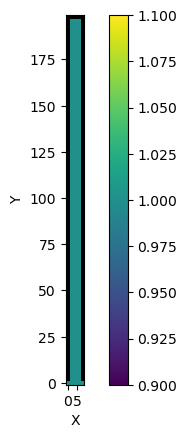

In [34]:
#### Code Block 3

from landlab.components import LithoLayers, Lithology

# make 400 layers, each 1 meter thick
layer_elevations = 2.0 * np.arange(-300, 100)

# we create a bottom layer that is very thick.
layer_elevations[-1] = layer_elevations[-2] + 1000

# Assign number of layers 
#make sure the number lines up with the number of layer elevations
layer_ids = np.tile([0, 1, 2, 3], 100)
# assign diffusivities and critical slope value to each layer 
attrs = {"D": {0: 0.01, 1: 0.01, 2: 0.01, 3: 0.0005}}

#Below combo has promise
#layer_ids = np.tile([0, 1, 2, 3], 100)
#attrs = {"D": {0: 0.01, 1: 0.01, 2: 0.01, 3: 0.001}}

# by making the lambda function not be a function of x or y, I think it will only vary with z
lith = LithoLayers(
    mg, layer_elevations, layer_ids, function=lambda x, y: (0.0 * x) + (0.0 * y), attrs=attrs)

mg.imshow("rock_type__id", cmap="viridis")

Now we import and initialize the *LinearDiffuser* component. 

In [35]:
# Code Block 3.5

from landlab.components import LinearDiffuser

ld = LinearDiffuser(mg, linear_diffusivity="D")

We now initialize a few more parameters.

In [36]:
# Code Block 4

# Uniform rate of rock uplift
uplift_rate = 0.0001  # meters/year, originally set to 0.0001

# Total time in years that the model will run for.
runtime = 300000  # years, originally set to 1,000,000

# Stability criteria for timestep dt.  Coefficient can be changed
# depending on our tolerance for stability vs tolerance for run time.
dt = 0.5 * mg.dx * mg.dx / 0.01

# nt is number of time steps
nt = int(runtime // dt)

# Below is to keep track of time for labeling plots
time_counter = 0

# length of uplift over a single time step, meters
uplift_per_step = uplift_rate * dt

from landlab.components import FlowAccumulator

fr = FlowAccumulator(mg)  # intializing flow routing

Now we figure out the analytical solution for the elevation of the steady-state profile using *linear diffusion*.

In [25]:
# Code Block 5

#ys = np.arange(mg.number_of_node_rows * mg.dx - mg.dx)

# location of divide or ridge crest 
# based on boundary conds.
#divide_loc = mg.number_of_node_rows * mg.dx - mg.dx 

# analytical solution for elevation under linear diffusion at steady state
#zs = (uplift_rate / (2 * D)) * (np.power(half_width, 2) - np.power(ys - divide_loc, 2))
#zs = (uplift_rate / (2 * 0.05)) * np.power(ys - 400 , 2)

Before we evolve the landscape, let's look at the initial topography. (This is just verifying that it is flat with zero elevation.)

Text(0.5, 1.0, 'initial topographic cross section')

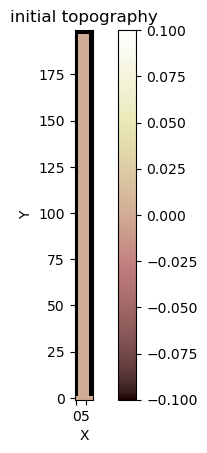

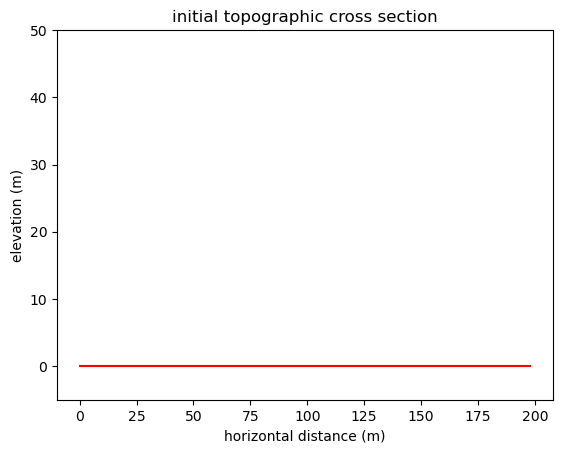

In [37]:
# Code Block 6

figure(1)
imshow_grid(mg, "topographic__elevation")
title("initial topography")
figure(2)
elev_rast = mg.node_vector_to_raster(mg.at_node["topographic__elevation"])
plot(ys_grid, elev_rast[:, 2], "r-", label="model")
#plot(ys, zs, "k--", label="analytical solution")
ylim((-5, 50))  # may want to change upper limit if D changes
xlabel("horizontal distance (m)")
ylabel("elevation (m)")
#legend(loc="lower center")
title("initial topographic cross section")

Now we are ready to evolve the landscape.

Below is the time loop that does all the calculations. 

maximum elevation is  44.4177506079


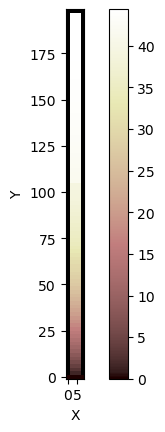

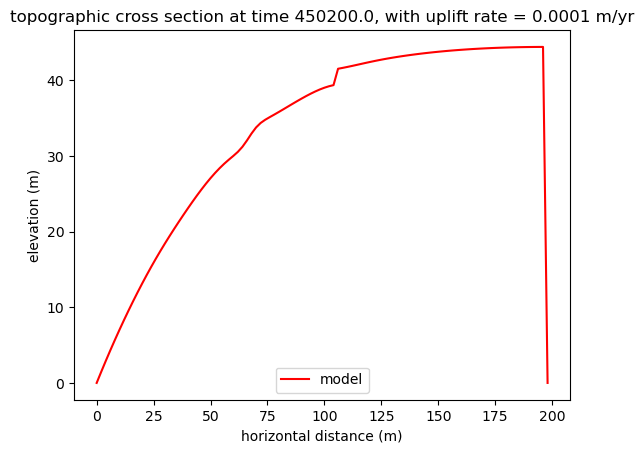

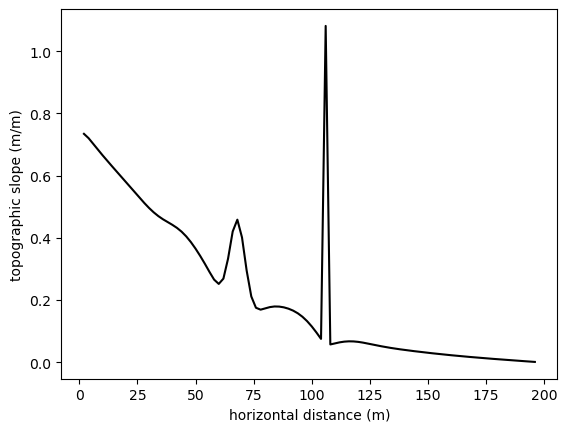

In [40]:
# Code Block 7

dz_ad = np.zeros(mg.size("node"))
dz_ad[mg.core_nodes] = uplift_per_step
lith.dz_advection = dz_ad

for i in range(nt):
    mg["node"]["topographic__elevation"][mg.core_nodes] += uplift_per_step
    lith.rock_id = mg.at_node["rock_type__id"]
    lith.run_one_step()
    ld.run_one_step(dt)
    time_counter += dt

    # All landscape evolution is the first four lines of loop.
    # Below is simply for plotting the topography halfway through the run
    if i == int(nt // 2):
        figure(1)
        imshow_grid(mg, "topographic__elevation")
        #title("topography at time %s, with D = %s, S_c = %s " % (time_counter, D, Sc))
        figure(2)
        elev_rast = mg.node_vector_to_raster(mg.at_node["topographic__elevation"])
        plot(ys_grid, elev_rast[:, 2], "r-", label="model")
        #plot(ys, zs, "k--", label="analytical solution - SS, linear diffusion")
        xlabel("horizontal distance (m)")
        ylabel("elevation (m)")
        legend(loc="lower center")
        title("topographic cross section at time %s, with uplift rate = %s m/yr" % (time_counter, uplift_rate))
        # title("topographic__elevation at time %s " % (time_counter))
        max_elev = np.max(elev_rast[:, 2])
        print("maximum elevation is ", max_elev)
        figure(3)
        fr.run_one_step()
        plot(
            mg.node_y[mg.core_nodes],
            mg.at_node["topographic__steepest_slope"][mg.core_nodes],
            "k-",
            )
        xlabel("horizontal distance (m)")
        ylabel("topographic slope (m/m)")
        #title("slope of the hillslope at time %s " % (time_counter))
        #max_slope = np.max(mg.at_node["topographic__steepest_slope"][mg.core_nodes])
        #print("maximum slope is ", max_slope)

Now we plot the final cross-section.

Text(0.5, 0, 'topographic slope (m/m)')

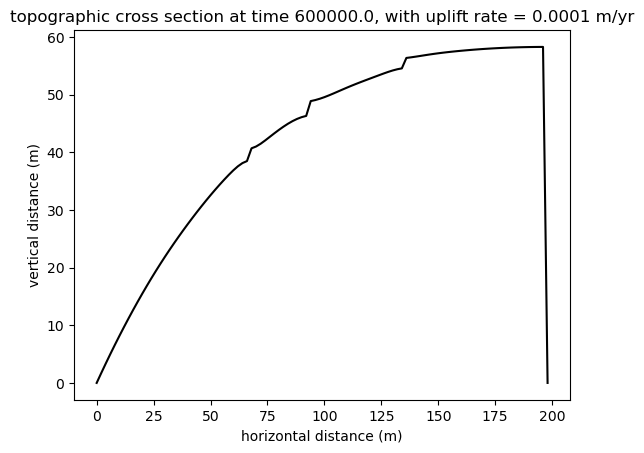

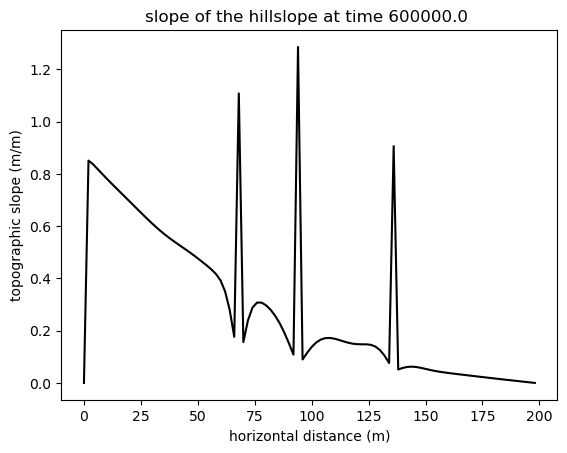

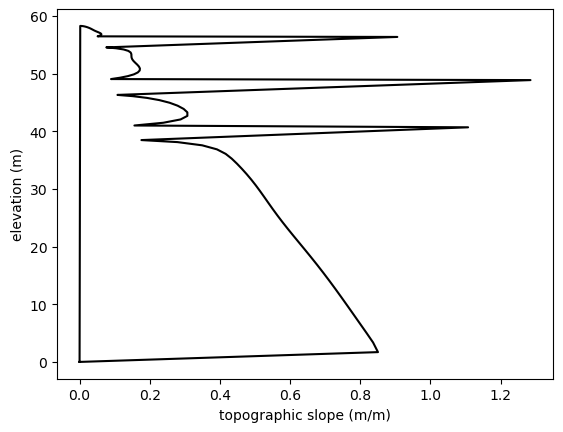

In [41]:
# Code Block 8

elev_rast = mg.node_vector_to_raster(mg.at_node["topographic__elevation"])
figure(1)
plot(ys_grid, elev_rast[:, 2], "k-", label="model")
#plot(ys, zs, "g--", label="analytical solution - SS, linear diffusion")
xlabel("horizontal distance (m)")
ylabel("vertical distance (m)")
title("topographic cross section at time %s, with uplift rate = %s m/yr" % (time_counter, uplift_rate))
#legend(loc="lower center")
#title("topographic cross section at time %s, with D = %s" % (time_counter, D))
figure(2)
fr.run_one_step()
slope_rast = mg.node_vector_to_raster(mg.at_node["topographic__steepest_slope"])
plot(ys_grid, slope_rast[:, 2], "k-")
#plot(
#            mg.node_y[mg.core_nodes],
#            mg.at_node["topographic__steepest_slope"][mg.core_nodes],
#            "k-",
#            )
xlabel("horizontal distance (m)")
ylabel("topographic slope (m/m)")
title("slope of the hillslope at time %s " % (time_counter))
#max_slope = np.max(mg.at_node["topographic__steepest_slope"][mg.core_nodes])
#print("maximum slope is ", max_slope)
figure(3)
plot(
            slope_rast[:, 2],
            elev_rast[:, 2],
            "k-",
            )
ylabel("elevation (m)")
xlabel("topographic slope (m/m)")

Now we plot the steepest slope in the downward direction across the landscape.

We can also plot a map of relief across the landscape. We will normalize by the size of the relief window.

Text(0.5, 1.0, 'relief of the hillslope at time 300000.0, window = 15 ')

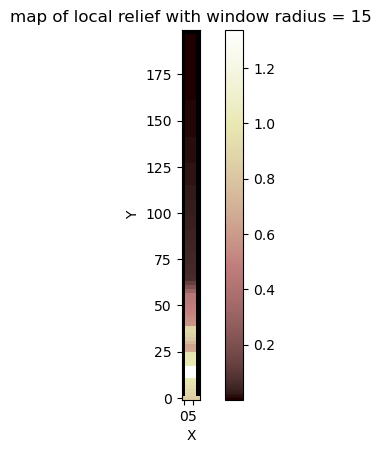

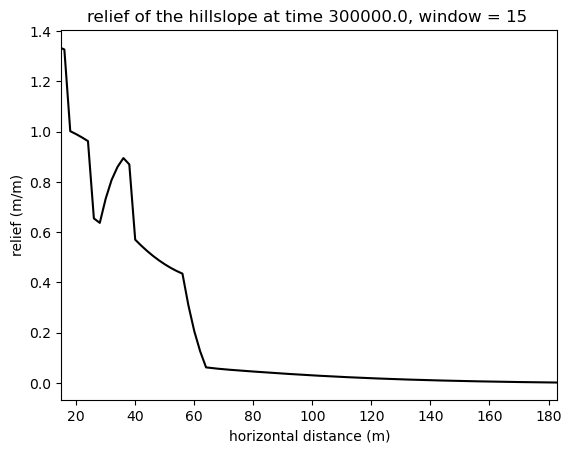

In [11]:
# Code Block 10

from landlab.utils import window_statistic

radius = 15

relief = window_statistic.calculate_window_statistic(mg,"topographic__elevation", np.ptp,search_radius=radius, calc_on_closed_nodes=False,)

figure(1)
imshow_grid(mg, relief/radius)
title("map of local relief with window radius = %s" % (radius))

figure(2)
ax=plot(
    mg.node_y[mg.core_nodes],
    relief[mg.core_nodes]/radius,
    "k-",
)
xlim([radius, np.max(mg.node_y)-radius])
xlabel("horizontal distance (m)")
ylabel("relief (m/m)")
title("relief of the hillslope at time %s, window = %s " % (time_counter, radius))

**Has the landscape reached steady state yet? How do you know?**

**What to do and hand in:**

This assignment is more "freeform" than the last one. Don't go overboard with your text. Use complete sentences to answer the questions, and usually 1 - 3 sentences will be enough.

1. From your experience with the linear diffusion model, you now know that if diffusivity is fixed, then a hillslope becomes steeper if the uplift/erosion rate is increased or the diffusivity is decreased. Run a few model cases to illustrate the same behavior holds at steady state using the nonlinear diffusion model. Describe the model sensitivity to erosion rate and diffusivity using plots and text. Is the nonlinear model as sensitive to changes in these paramaters as the linear model? Make sure it is clear how you are making your assesment of what it means to be more or less sensitive.
2. How does changing $S_c$ impact hillslope form at steady state? Do some model runs to illustrate hillslope sensitivity to $S_c$. Make sure you include plots and text to describe your findings.
3. If relief is defined as the difference between maximum and minimum elevation, do hillslopes evolved with the linear or nonlinear model have more relief? Compare hillslopes with the same $D$ value between the two models. Use plots and text to support your answer. (This is a very unconstrained question. I'm just trying to get you thinking about the slopes and relief produced using the different models. You may find that some hillslope forms don't seem realistic. This is a model, and that is OK.)
4. On two hillslopes with different $S_c$, but the same erosion rate and $D$, explore the patterns of relief produced at steady state (Code Block 10). How does the radius over which relief is calculated impact the patterns of relief you see across the hillslope? Does the pattern change with the different values of $S_c$? Again, this is a very unconstrained question. Explore, describe what you find using full sentences and plots.